In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    "pdf.fonttype": 42,  # Make fonts editable in Adobe Illustrator
    "ps.fonttype": 42,  # Make fonts editable in Adobe Illustrator
    "axes.labelcolor": "#222222",
    "axes.labelsize": 9,
    "text.color": "#222222",
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "figure.figsize": (7.2, 4.45),
    "xtick.major.size": 0.00,
    "ytick.major.size": 0.00,
    "axes.labelpad": 0.1,
}
sns.set(style="white", context="paper", rc=rc_params, font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


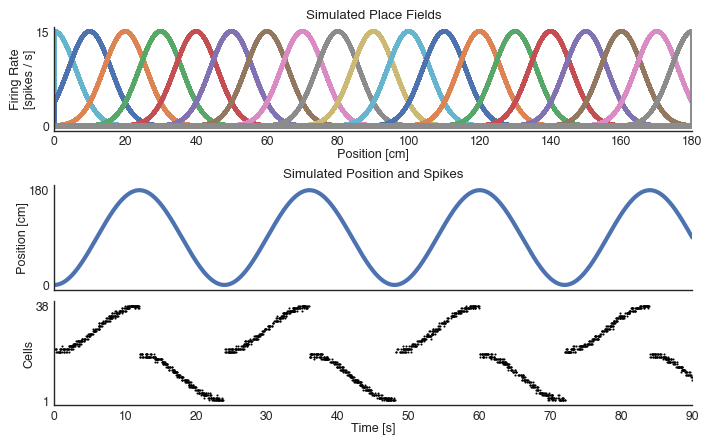

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_simulated_run_data,
)

MM_TO_INCHES = 1.0 / 25.4
ONE_COLUMN = 89.0 * MM_TO_INCHES
ONE_AND_HALF_COLUMN = 140.0 * MM_TO_INCHES
TWO_COLUMN = 178.0 * MM_TO_INCHES
PAGE_HEIGHT = 247.0 * MM_TO_INCHES
GOLDEN_RATIO = (np.sqrt(5) - 1.0) / 2.0

time, linear_distance, sampling_frequency, spikes, place_fields = (
    make_simulated_run_data(make_inbound_outbound_neurons=True)
)
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap("tab20")

fig, axes = plt.subplots(
    3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True
)
for place_field in place_fields.T:
    axes[0].plot(linear_distance, place_field, linewidth=3)
axes[0].set_xlabel("Position [cm]")
axes[0].set_ylabel("Firing Rate\n[spikes / s]")
axes[0].set_title("Simulated Place Fields")
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel("Position [cm]")
axes[1].set_title("Simulated Position and Spikes")
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))


axes[2].scatter(time[spike_ind], neuron_ind + 1, c="black", s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel("Cells")

axes[2].set_xlabel("Time [s]")
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [ ]:
from dask.distributed import Client

Client(n_workers=2, threads_per_worker=2, processes=True, memory_limit="25GB")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/dask-scratch-space/scheduler-9ywwhgnt', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/dask-scratch-space/worker-3hmves4n', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/dask-scratch-space/worker-k21psl5k', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:62137
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:62140'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62137,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:62145,Total threads: 2
Dashboard: http://127.0.0.1:62147/status,Memory: 23.28 GiB
Nanny: tcp://127.0.0.1:62140,


INFO:distributed.core:Event loop was unresponsive in Nanny for 162.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 162.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 162.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 31.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 31.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause

In [5]:
def get_trajectory_direction(linear_distance):
    is_inbound = np.insert(np.diff(linear_distance) < 0, 0, False)
    return np.where(is_inbound, "Inbound", "Outbound"), is_inbound


encoding_labels, is_inbound = get_trajectory_direction(linear_distance)

In [6]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import (
    RandomWalk,
    Uniform,
)
from replay_trajectory_classification.observation_model import ObservationModel


movement_var = estimate_movement_var(linear_distance, sampling_frequency)
environment = Environment(place_bin_size=np.sqrt(movement_var))

random_walk = RandomWalk(movement_var=movement_var * 120)
uniform = Uniform()
continuous_transition_types = [
    [random_walk, uniform, uniform, uniform],
    [uniform, uniform, uniform, uniform],
    [uniform, uniform, random_walk, uniform],
    [uniform, uniform, uniform, uniform],
]

observation_models = [
    ObservationModel(encoding_group="Inbound"),
    ObservationModel(encoding_group="Inbound"),
    ObservationModel(encoding_group="Outbound"),
    ObservationModel(encoding_group="Outbound"),
]

classifier = SortedSpikesClassifier(
    environments=environment,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types,
)
classifier.fit(linear_distance, spikes, encoding_group_labels=encoding_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/spiking_likelihood_kde.py:119: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy))


,environments,"(Environment(e...t_threshold=0),)"
,observation_models,"[ObservationMo...oup='Inbound'), ObservationMo...oup='Inbound'), ...]"
,continuous_transition_types,"[[RandomWalk(en...ffusion=False), Uniform(envir...nt2_name=None), ...], [Uniform(envir...nt2_name=None), Uniform(envir...nt2_name=None), ...], ...]"
,discrete_transition_type,DiagonalDiscr...al_value=0.98)
,initial_conditions_type,UniformInitialConditions()
,infer_track_interior,True
,sorted_spikes_algorithm,'spiking_likelihood_kde'
,sorted_spikes_algorithm_params,"{'block_size': None, 'position_std': 6.0, 'use_diffusion': False}"


In [7]:
classifier.place_fields_

{('',
  'Inbound'): <xarray.DataArray (position: 342, neuron: 38)> Size: 104kB
 array([[0.01280062, 0.00785768, 0.00072406, ..., 0.        , 0.        ,
         0.        ],
        [0.01258835, 0.00800302, 0.00078132, ..., 0.        , 0.        ,
         0.        ],
        [0.01236454, 0.00815516, 0.00084471, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], shape=(342, 38))
 Coordinates:
   * position  (position) float32 1kB 0.2632 0.7895 1.316 ... 178.7 179.2 179.7
 Dimensions without coordinates: neuron,
 ('',
  'Outbound'): <xarray.DataArray (position: 342, neuron: 38)> Size: 104kB
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
   

In [8]:
# g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', hue='encoding_group',
#                                                          col_wrap=9)

In [9]:
def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(
        3, 1, figsize=(10, 6), constrained_layout=True, sharex=True
    )
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(
        replay_time[spike_time_ind],
        neuron_ind,
        color="black",
        zorder=1,
        marker="|",
        s=80,
        linewidth=3,
        clip_on=False,
    )
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel("Neuron Index")
    replay_probability = results.acausal_posterior.sum("position")
    for state, prob in replay_probability.groupby("state"):
        axes[1].plot(prob.time, prob.values, linewidth=2, label=state)
    axes[1].set_ylabel("Probability")
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend()

    results.acausal_posterior.sum("state").plot(
        x="time", y="position", robust=True, vmin=0.0, ax=axes[2]
    )
    axes[2].set_ylabel("Position [cm]")
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel("Time [ms]")
    sns.despine()

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/core.py:210: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


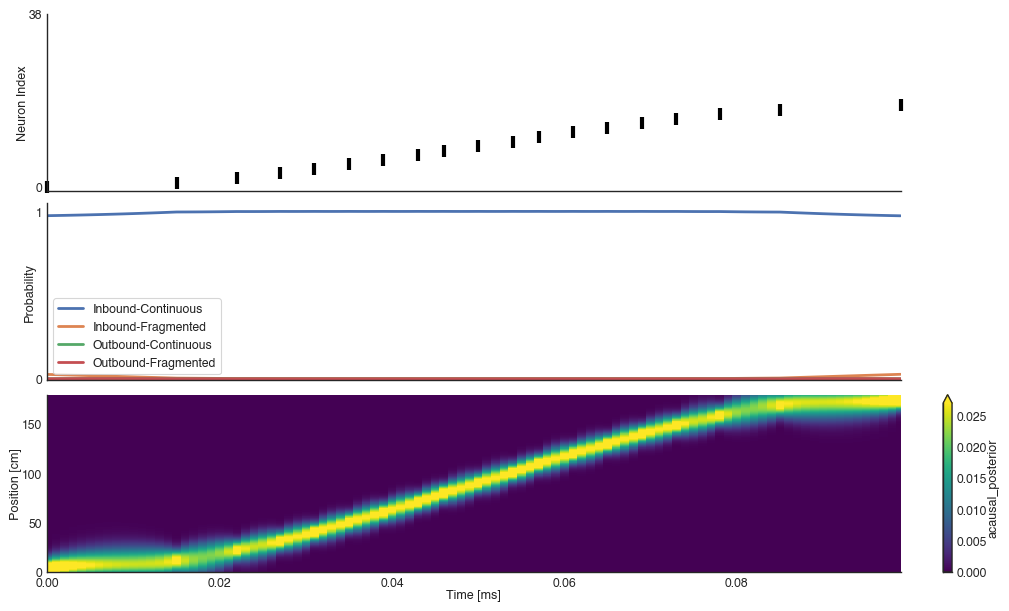

In [10]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_continuous_replay,
)

state_names = [
    "Inbound-Continuous",
    "Inbound-Fragmented",
    "Outbound-Continuous",
    "Outbound-Fragmented",
]

replay_time, test_spikes = make_continuous_replay()
test_spikes = np.concatenate((test_spikes, np.zeros_like(test_spikes)), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


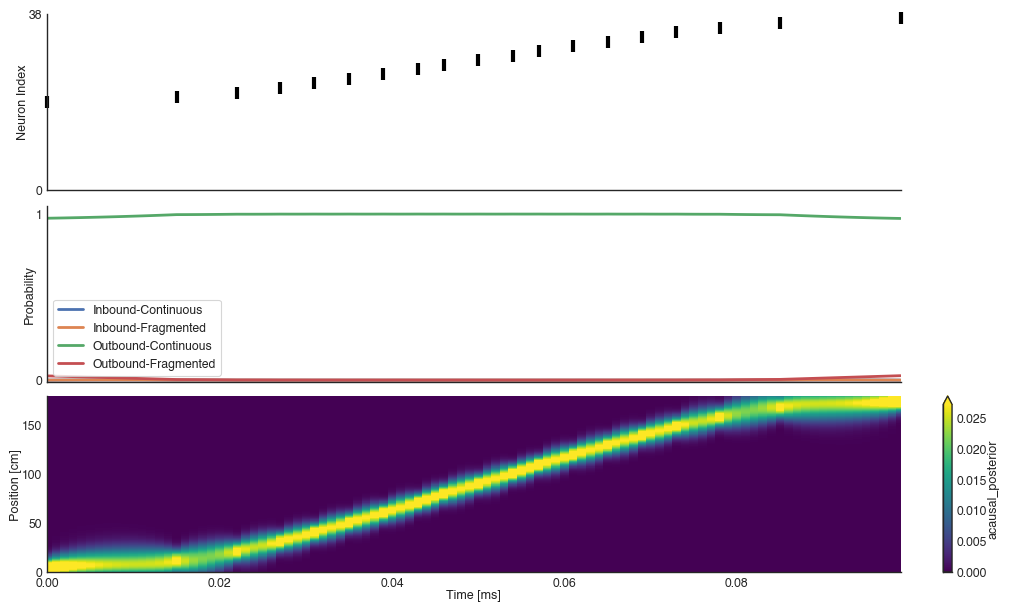

In [11]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_continuous_replay,
)

replay_time, test_spikes = make_continuous_replay()
test_spikes = np.concatenate((np.zeros_like(test_spikes), test_spikes), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


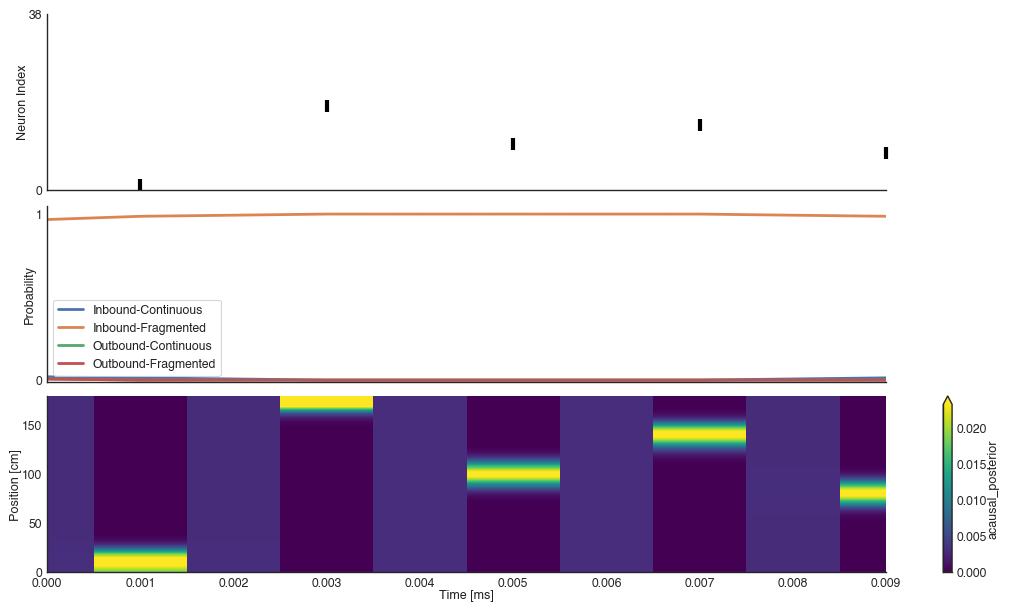

In [12]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_replay,
)

replay_time, test_spikes = make_fragmented_replay()
test_spikes = np.concatenate((test_spikes, np.zeros_like(test_spikes)), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


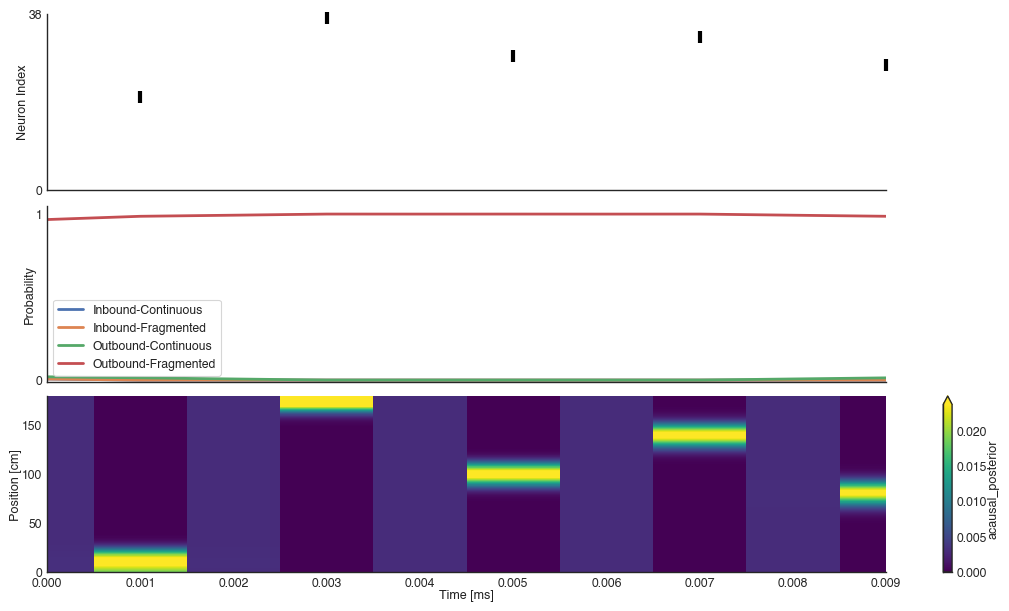

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_replay,
)

replay_time, test_spikes = make_fragmented_replay()
test_spikes = np.concatenate((np.zeros_like(test_spikes), test_spikes), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

## Clusterless

(0.0, 349.999)

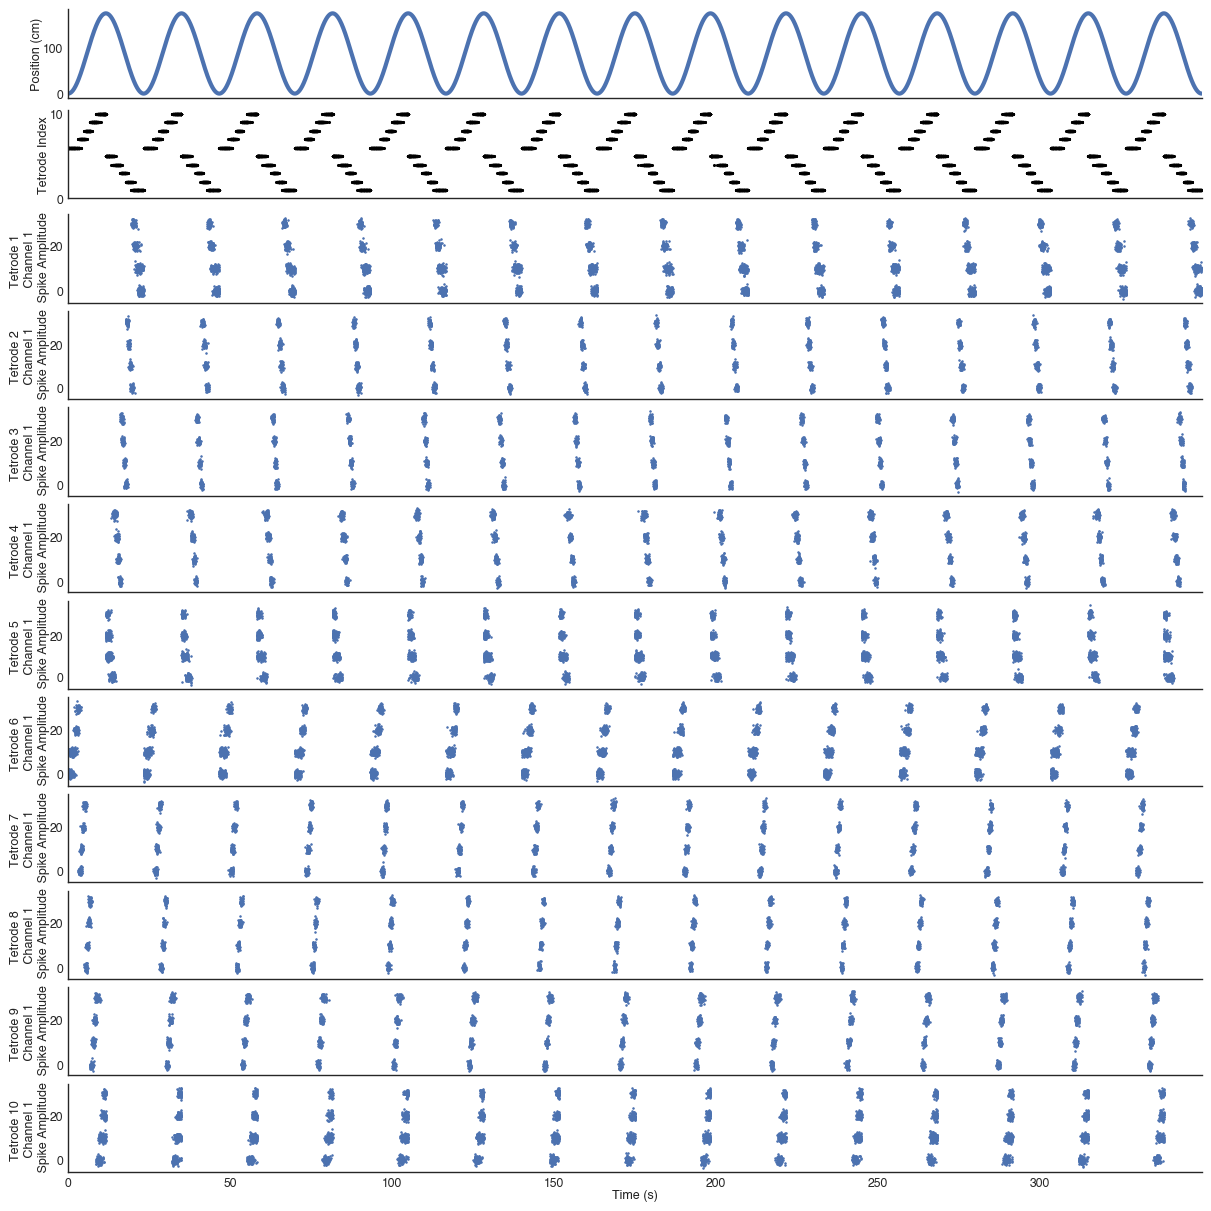

In [14]:
from replay_trajectory_classification.clusterless_simulation import (
    make_simulated_run_data,
)

(time, linear_distance, sampling_frequency, multiunits, multiunits_spikes) = (
    make_simulated_run_data(make_inbound_outbound_neurons=True)
)

spike_ind, neuron_ind = np.nonzero(multiunits_spikes)
n_tetrodes = multiunits.shape[-1]

fig, axes = plt.subplots(
    n_tetrodes + 2, 1, figsize=(12, 12), constrained_layout=True, sharex=True
)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel("Position (cm)")

axes[1].scatter(time[spike_ind], neuron_ind + 1, color="black", s=2)
axes[1].set_yticks((0, multiunits_spikes.shape[1]))
axes[1].set_ylabel("Tetrode Index")

for tetrode_ind in range(n_tetrodes):
    axes[2 + tetrode_ind].scatter(time, multiunits[:, 0, tetrode_ind], s=1)
    axes[2 + tetrode_ind].set_ylabel(
        f"Tetrode {tetrode_ind + 1} \n Channel 1 \n Spike Amplitude"
    )

sns.despine()
axes[-1].set_xlabel("Time (s)")
axes[-1].set_xlim((time.min(), time.max()))

In [15]:
encoding_labels, is_inbound = get_trajectory_direction(linear_distance)

In [26]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)


random_walk = RandomWalk(movement_var=movement_var * 120)
uniform = Uniform()
continuous_transition_types = [
    [random_walk, uniform, uniform, uniform],
    [uniform, uniform, uniform, uniform],
    [uniform, uniform, random_walk, uniform],
    [uniform, uniform, uniform, uniform],
]

clusterless_algorithm = "multiunit_likelihood"
clusterless_algorithm_params = {
    "mark_std": 1.0,
    "position_std": 12.5,
}

observation_models = [
    ObservationModel(encoding_group="Inbound"),
    ObservationModel(encoding_group="Inbound"),
    ObservationModel(encoding_group="Outbound"),
    ObservationModel(encoding_group="Outbound"),
]


classifier = ClusterlessClassifier(
    environments=environment,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params,
)

classifier.fit(linear_distance, multiunits, encoding_group_labels=encoding_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)


,environments,"(Environment(e...t_threshold=0),)"
,observation_models,"[ObservationMo...oup='Inbound'), ObservationMo...oup='Inbound'), ...]"
,continuous_transition_types,"[[RandomWalk(en...ffusion=False), Uniform(envir...nt2_name=None), ...], [Uniform(envir...nt2_name=None), Uniform(envir...nt2_name=None), ...], ...]"
,discrete_transition_type,DiagonalDiscr...al_value=0.98)
,initial_conditions_type,UniformInitialConditions()
,infer_track_interior,True
,clusterless_algorithm,'multiunit_likelihood'
,clusterless_algorithm_params,"{'mark_std': 1.0, 'position_std': 12.5}"


In [17]:
classifier.encoding_model_[("", "Inbound")].keys()

dict_keys(['encoding_marks', 'encoding_positions', 'summed_ground_process_intensity', 'occupancy', 'mean_rates', 'mark_std', 'position_std', 'block_size', 'bin_diffusion_distances', 'use_diffusion', 'edges'])

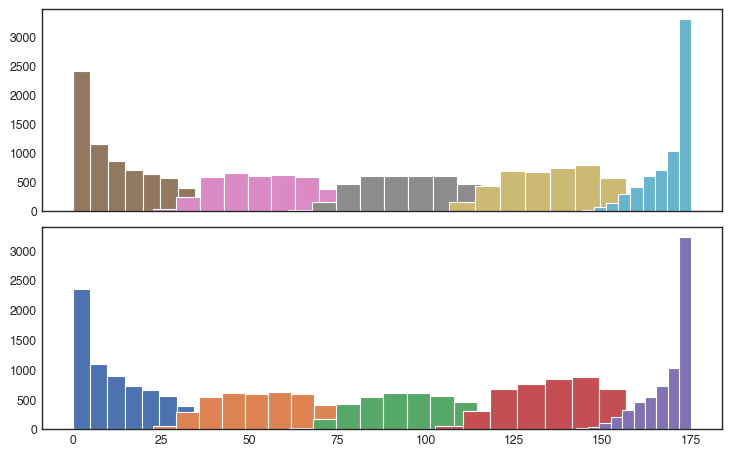

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
for pos in classifier.encoding_model_[("", "Outbound")]["encoding_positions"]:
    axes[0].hist(pos)
for pos in classifier.encoding_model_[("", "Inbound")]["encoding_positions"]:
    axes[1].hist(pos)

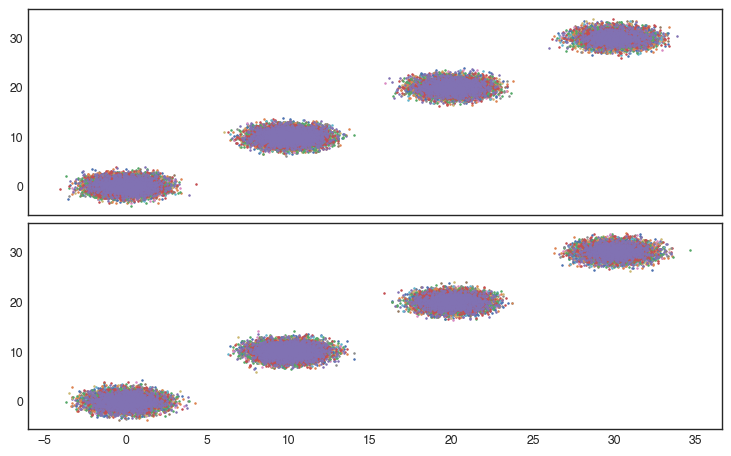

In [19]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
for marks in classifier.encoding_model_[("", "Outbound")]["encoding_marks"]:
    for mark1, mark2 in zip(marks.T[:-1], marks.T[1:]):
        axes[0].scatter(mark1, mark2, s=1)

for marks in classifier.encoding_model_[("", "Inbound")]["encoding_marks"]:
    for mark1, mark2 in zip(marks.T[:-1], marks.T[1:]):
        axes[1].scatter(mark1, mark2, s=1)

In [20]:
def plot_classification(replay_time, test_multiunits, results):
    fig, axes = plt.subplots(
        3, 1, figsize=(12, 10), constrained_layout=True, sharex=True
    )
    test_multiunit_spikes = np.any(~np.isnan(test_multiunits), axis=1)
    spike_time_ind, neuron_ind = np.nonzero(test_multiunit_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color="black")
    axes[0].set_yticks((0, test_multiunit_spikes.shape[1]))
    axes[0].set_ylabel("Tetrode Index")

    replay_probabilities = results.acausal_posterior.sum("position")
    for state, probability in replay_probabilities.groupby("state"):
        probability.plot(x="time", linewidth=2, ax=axes[1], label=state)
    axes[1].set_ylabel("Probability")
    axes[1].set_ylim((0.0, 1.05))
    axes[1].set_title("")
    axes[1].legend()

    results.acausal_posterior.sum("state").plot(
        x="time", y="position", robust=True, vmin=0.0, ax=axes[2]
    )
    plt.xlim((replay_time.min(), replay_time.max()))
    sns.despine()

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:183: RuntimeWarning: invalid value encountered in divide
  mark_distance @ position_distance / n_encoding_spikes, occupancy, mean_rate
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


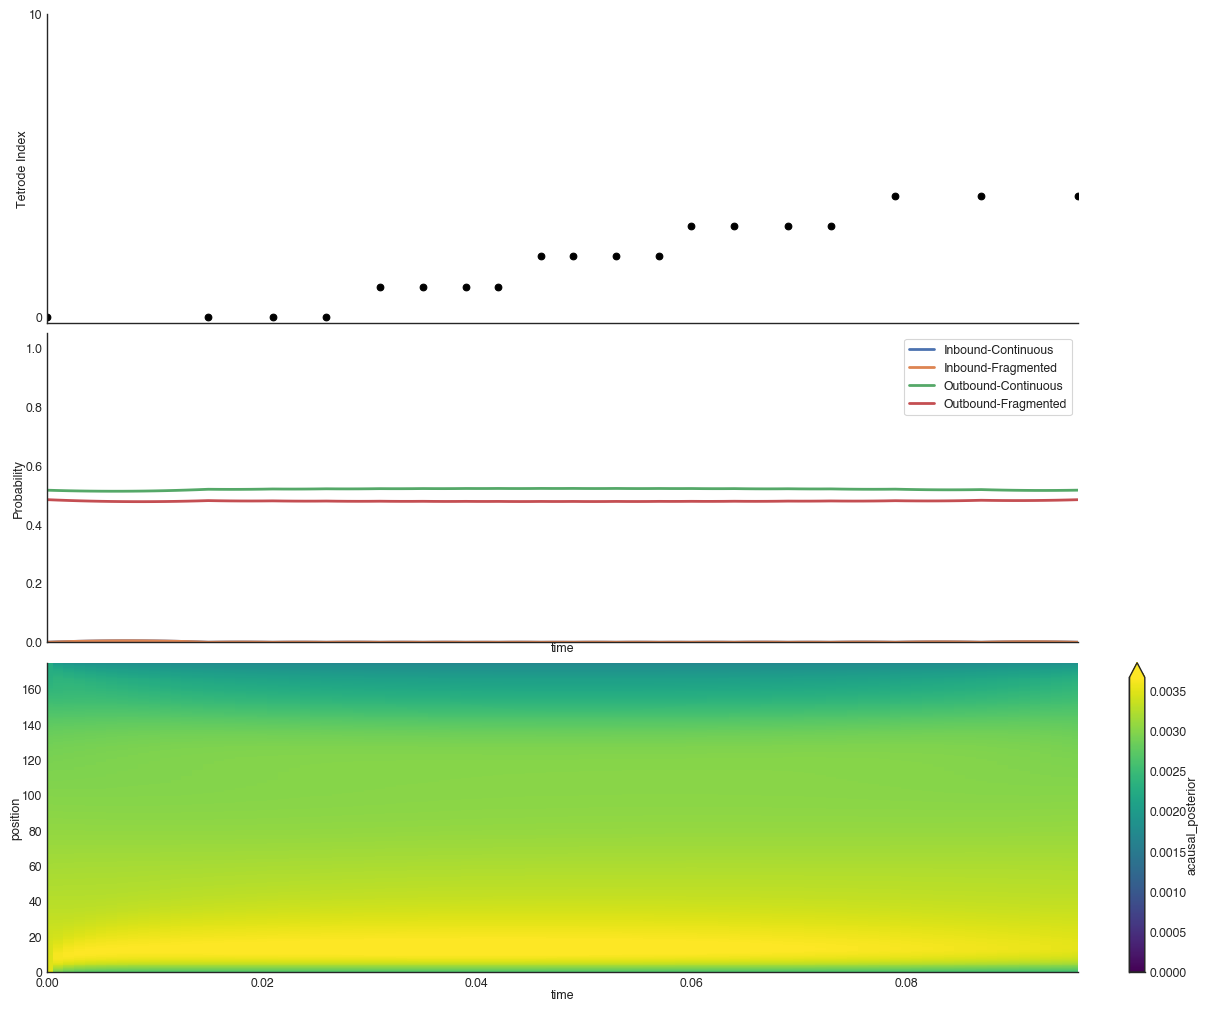

In [21]:
from replay_trajectory_classification.clusterless_simulation import (
    make_continuous_replay,
)

replay_time, test_multiunits = make_continuous_replay()
test_multiunits = np.concatenate(
    (test_multiunits, np.full_like(test_multiunits, np.nan)), axis=-1
)
results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:183: RuntimeWarning: invalid value encountered in divide
  mark_distance @ position_distance / n_encoding_spikes, occupancy, mean_rate
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


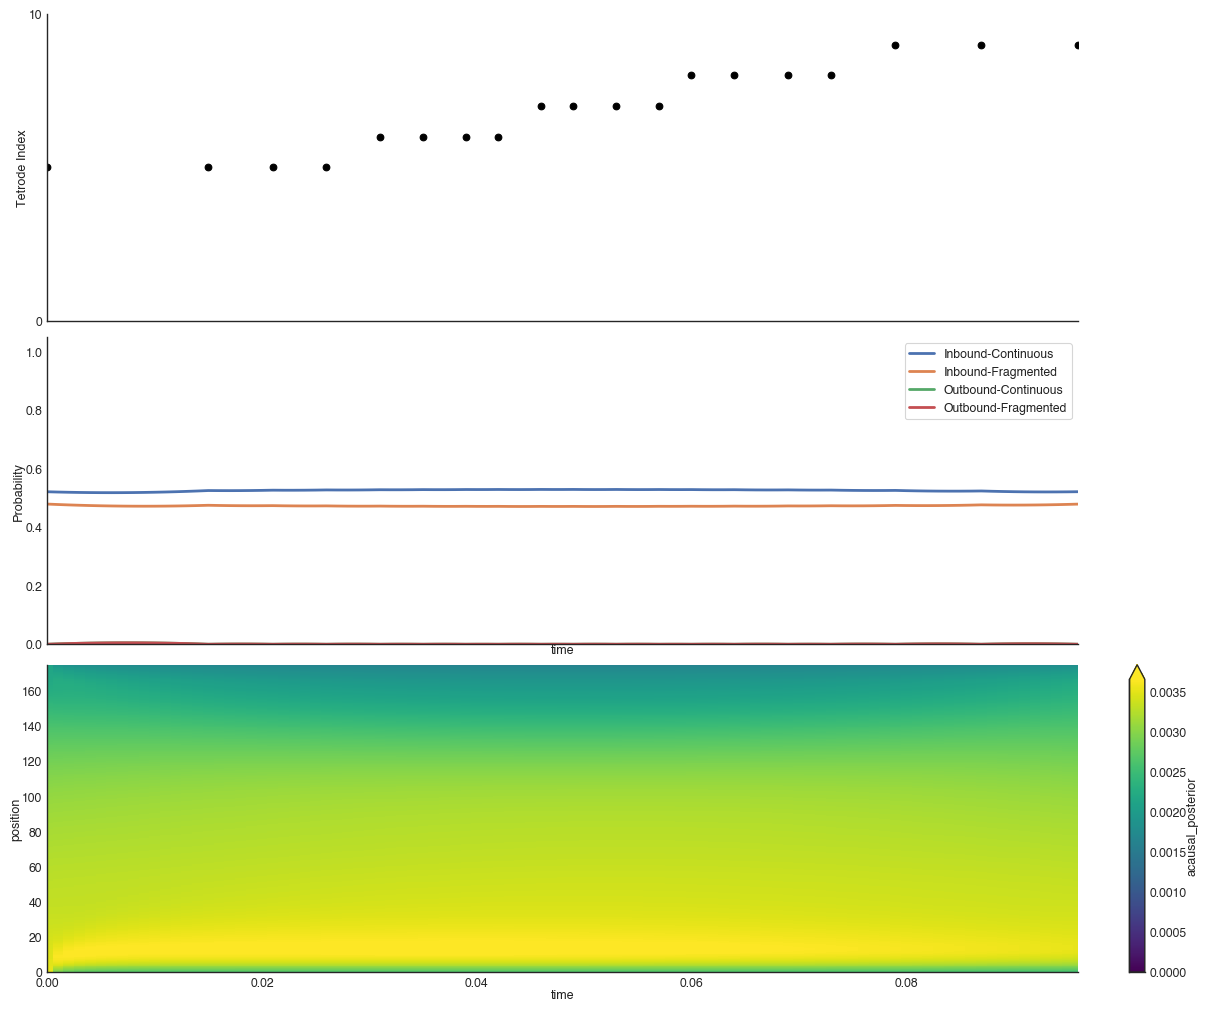

In [22]:
from replay_trajectory_classification.clusterless_simulation import (
    make_continuous_replay,
)

replay_time, test_multiunits = make_continuous_replay()
test_multiunits = np.concatenate(
    (np.full_like(test_multiunits, np.nan), test_multiunits), axis=-1
)
results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:183: RuntimeWarning: invalid value encountered in divide
  mark_distance @ position_distance / n_encoding_spikes, occupancy, mean_rate
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


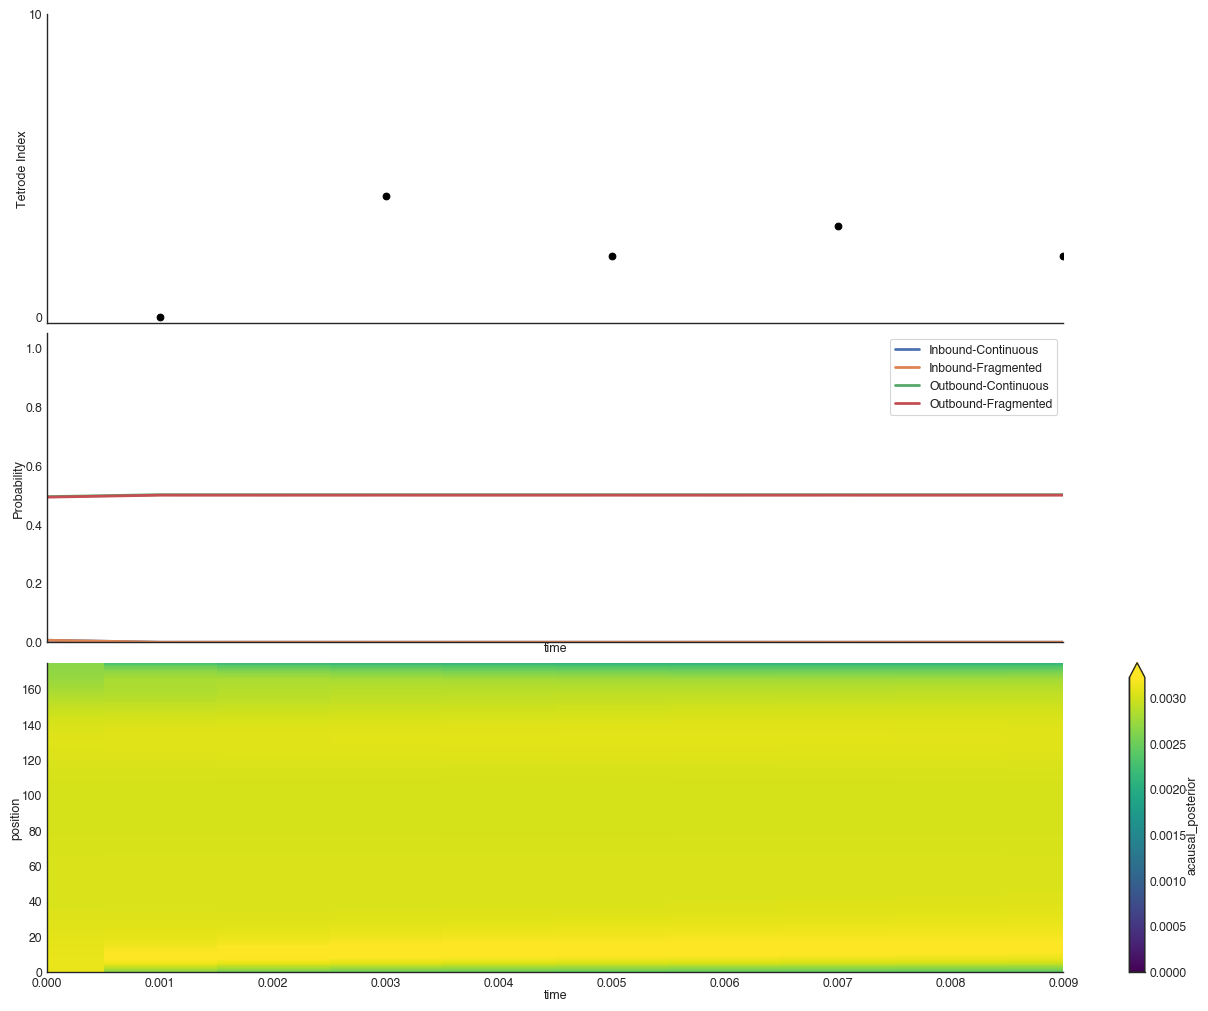

In [23]:
from replay_trajectory_classification.clusterless_simulation import (
    make_fragmented_replay,
)

replay_time, test_multiunits = make_fragmented_replay()
test_multiunits = np.concatenate(
    (test_multiunits, np.full_like(test_multiunits, np.nan)), axis=-1
)
results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:183: RuntimeWarning: invalid value encountered in divide
  mark_distance @ position_distance / n_encoding_spikes, occupancy, mean_rate
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)


n_electrodes:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


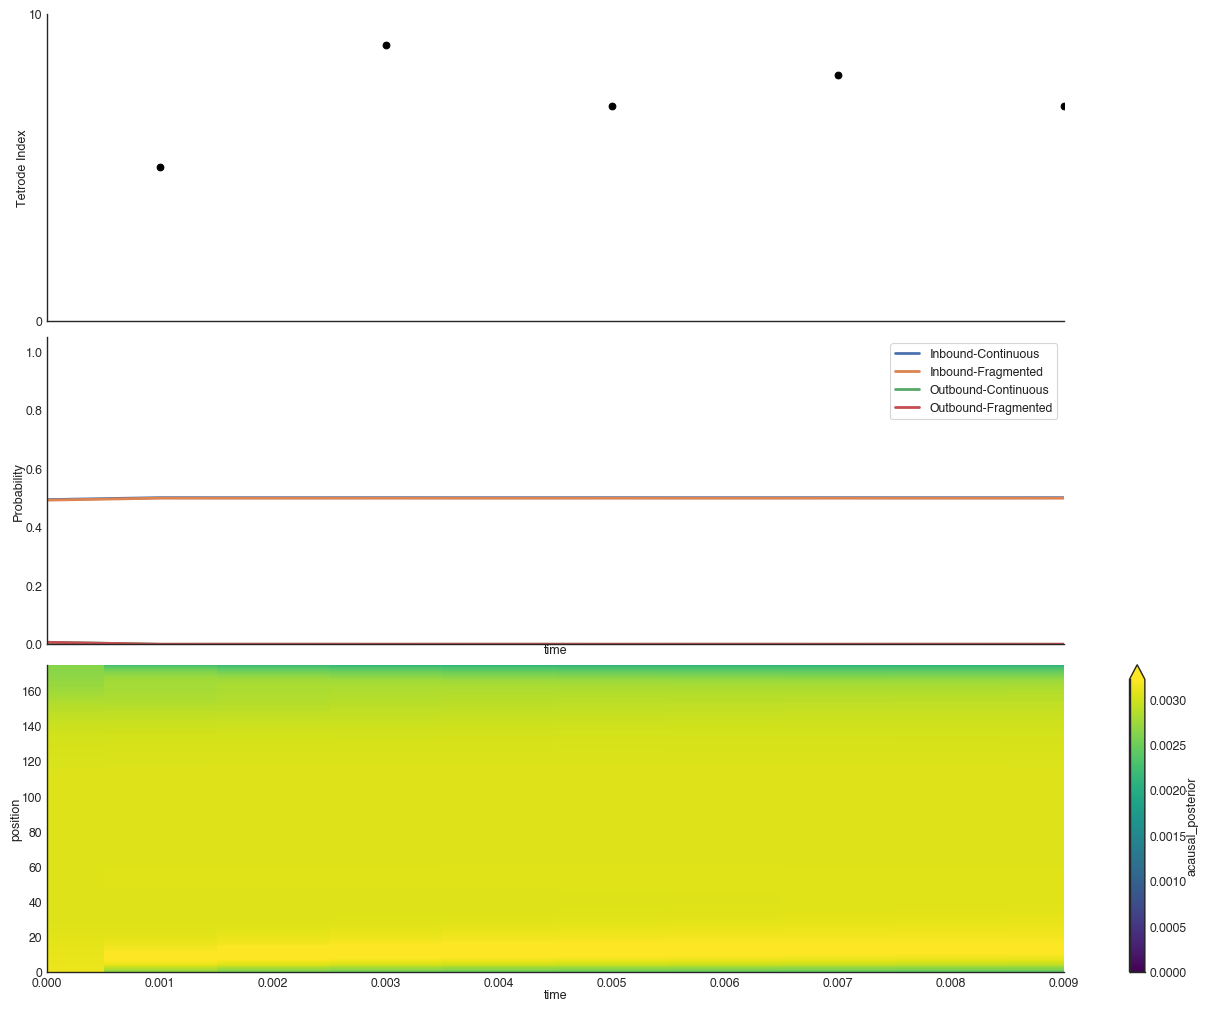

In [24]:
from replay_trajectory_classification.clusterless_simulation import (
    make_fragmented_replay,
)

replay_time, test_multiunits = make_fragmented_replay()
test_multiunits = np.concatenate(
    (np.full_like(test_multiunits, np.nan), test_multiunits), axis=-1
)
results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

In [25]:
# place field center, directionality, tetrode, and mark space position